In [1]:
conda config --add channels pytorch  


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install required packages if you have not installed them already
!pip install -r requirements.txt --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rich 13.9.3 requires pygments<3.0.0,>=2.13.0, but you have pygments 2.12.0 which is incompatible.


In [3]:
import sys
sys.path.append('.')
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from PIL import Image

import numpy as np
import os
import time
# import spaces  # Import spaces for ZeroGPU compatibility

Python version is above 3.10, patching the collections module.


/opt/conda/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:517: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [4]:
import os
os.environ["HF_HOME"] = "/home/jovyan/local/hugging_face"
os.environ["HF_HUB_CACHE"] = "/home/jovyan/local/hugging_face/hub"

In [5]:
print(f'cuda:------------------:{torch.cuda.is_available()}')

cuda:------------------:True


In [6]:
# Load model and processor
model_path = "deepseek-ai/Janus-Pro-1B"

In [7]:
config = AutoConfig.from_pretrained(model_path)

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

In [8]:
language_config = config.language_config

In [9]:
language_config._attn_implementation = 'eager'

In [10]:
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)

pytorch_model.bin:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

In [11]:
print(f'cuda:------------------:{torch.cuda.is_available()}')

if torch.cuda.is_available():
    vl_gpt = vl_gpt.to(torch.bfloat16).cuda()
else:
    vl_gpt = vl_gpt.to(torch.float16)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'cpu'

cuda:------------------:True


preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: image_tag, sft_format, num_image_tokens, add_special_token, ignore_id, mask_prompt. 


In [12]:
@torch.inference_mode()
# @spaces.GPU(duration=120)  # Specify a duration to avoid timeout
def generate_image(prompt,
                   seed=None,
                   guidance=5,
                   t2i_temperature=1.0):
    # Clear CUDA cache and avoid tracking gradients
    torch.cuda.empty_cache()
    # Set the seed for reproducible results
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
    width = 384
    height = 384
    parallel_size = 5
    
    with torch.no_grad():
        messages = [{'role': '<|User|>', 'content': prompt},
                    {'role': '<|Assistant|>', 'content': ''}]
        text = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(conversations=messages,
                                                                   sft_format=vl_chat_processor.sft_format,
                                                                   system_prompt='')
        text = text + vl_chat_processor.image_start_tag
        
        input_ids = torch.LongTensor(tokenizer.encode(text))
        output, patches = generate(input_ids,
                                   width // 16 * 16,
                                   height // 16 * 16,
                                   cfg_weight=guidance,
                                   parallel_size=parallel_size,
                                   temperature=t2i_temperature)
        images = unpack(patches,
                        width // 16 * 16,
                        height // 16 * 16,
                        parallel_size=parallel_size)

        return [Image.fromarray(images[i]).resize((768, 768), Image.LANCZOS) for i in range(parallel_size)]


In [13]:
def generate(input_ids,
             width,
             height,
             temperature: float = 1,
             parallel_size: int = 5,
             cfg_weight: float = 5,
             image_token_num_per_image: int = 576,
             patch_size: int = 16):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()
    
    tokens = torch.zeros((parallel_size * 2, len(input_ids)), dtype=torch.int).to(cuda_device)
    for i in range(parallel_size * 2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id
    inputs_embeds = vl_gpt.language_model.get_input_embeddings()(tokens)
    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).to(cuda_device)

    pkv = None
    for i in range(image_token_num_per_image):
        with torch.no_grad():
            outputs = vl_gpt.language_model.model(inputs_embeds=inputs_embeds,
                                                use_cache=True,
                                                past_key_values=pkv)
            pkv = outputs.past_key_values
            hidden_states = outputs.last_hidden_state
            logits = vl_gpt.gen_head(hidden_states[:, -1, :])
            logit_cond = logits[0::2, :]
            logit_uncond = logits[1::2, :]
            logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
            probs = torch.softmax(logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated_tokens[:, i] = next_token.squeeze(dim=-1)
            next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)

            img_embeds = vl_gpt.prepare_gen_img_embeds(next_token)
            inputs_embeds = img_embeds.unsqueeze(dim=1)

    

    patches = vl_gpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int),
                                                 shape=[parallel_size, 8, width // patch_size, height // patch_size])

    return generated_tokens.to(dtype=torch.int), patches

def unpack(dec, width, height, parallel_size=5):
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)
    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, width, height, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    return visual_img


i = generate_image('A high-tech automotive manufacturing facility with advanced robotic arms assembling a sleek, modern electric vehicle. The factory floor is illuminated with bright overhead lighting, showcasing an efficient, automated production line. Engineers in safety gear monitor digital displays and futuristic control panels. The background features conveyor belts transporting car parts, robotic welders in action, and a quality control inspection area. The scene conveys precision, innovation, and cutting-edge technology in the automotive industry.')

We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


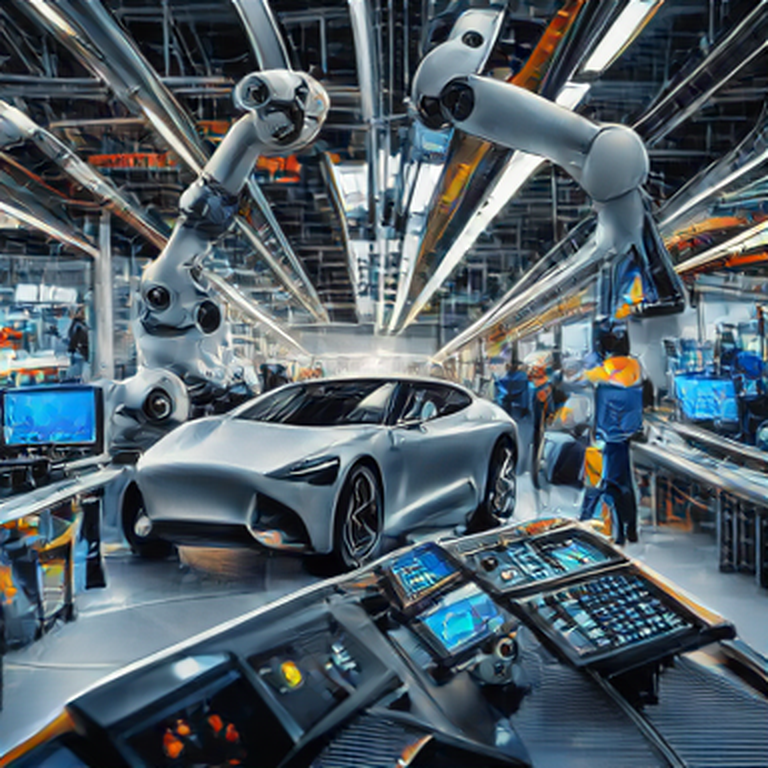

In [14]:
i[0]